In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Min: 42
Max: 88
Unique values: [42 45 50 55 59 63 68 72 76 81]
Is integer: True


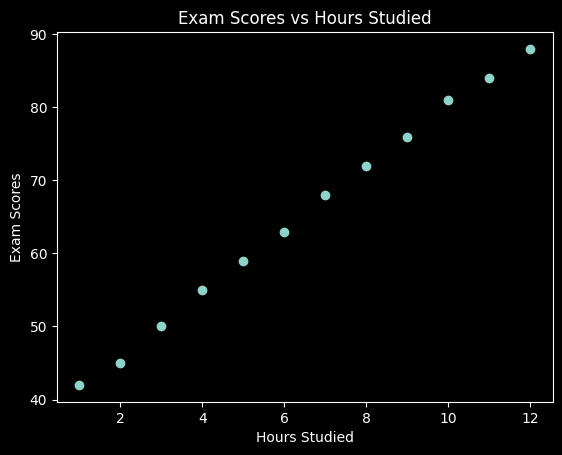

In [4]:
data = pd.read_csv('glm.csv')
x = data['hours_studied']
y = data['exam_scores']
plt.scatter(x, y)
plt.xlabel('Hours Studied')
plt.ylabel('Exam Scores')
plt.title('Exam Scores vs Hours Studied')
print("Min:", y.min())
print("Max:", y.max())
print("Unique values:", np.unique(y)[:10])
print("Is integer:", np.all(np.mod(y, 1) == 0))

In [ ]:
#since the output variable is discrete and non-negative, we can use Poisson regression

